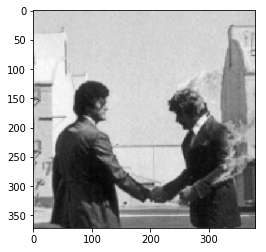

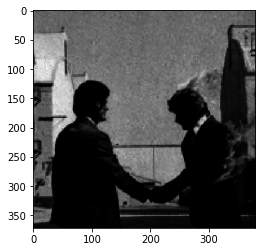

In [2]:
"""

exercise: PIL, matplotlib

"""

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

im_gray = np.array(Image.open('floyd.png').convert('L'))

plt.figure
plt.imshow(im_gray,cmap='gray')
plt.show()

plt.figure
plt.imshow((im_gray/255.)**5,cmap='gray')
plt.show()


In [ ]:
"""

exercise: histogram equalizer

"""

def histeq(im,nbr_bins=256):
    """ Histogram equalization of a grayscale image. """
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)  # get image histogram
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize
    im2 = np.interp(im.flatten(),bins[:-1],cdf) # use linear interpolation of cdf to find new pixel values
    return im2.reshape(im.shape), cdf

im_new, cdf = histeq(im_gray)

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.imshow(im_gray,cmap='gray')
plt.title('wish you were here...')
plt.subplot(2,2,2)
plt.imshow(im_new,cmap='gray')
plt.subplot(2,2,3)
hist,bins = np.histogram(im_gray.flatten(),100)
plt.plot(hist)
plt.subplot(2,2,4)
hist,bins = np.histogram(im_new.flatten(),100)
plt.plot(hist)
plt.show()

In [ ]:
"""

exercise: PCA dimred

"""

from mnist import MNIST
mndata = MNIST('/Users/dasein/Desktop/work/work-scripts/data/mnist')
imlist = mndata.load_training()
X_train = np.array(imlist[0])



In [ ]:

def pca(X):
    """ Principal Component Analysis
    input: X, matrix with training data stored as flattened arrays in rows
    return: projection matrix (with important dimensions first), variance and mean.
    """
    # get dimensions
    num_data,dim = X.shape
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    if dim>num_data:
        # PCA - compact trick used
        M = np.dot(X,X.T) # covariance matrix
        e,EV = np.linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = np.dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = np.sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = np.linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
        # return the projection matrix, the variance and the mean
    return V,S,mean_X

V, S, mean_X = pca(X_train[:1000,:])

print(V.shape)

n = 28
plt.figure
plt.imshow(np.reshape(X_train[0,:],(n,n)))
plt.show()

plt.figure
plt.imshow(np.reshape(V[1,:],(n,n)))
plt.show()


In [ ]:
"""

exercise: pickling

"""

import pickle

f = open('font_pca_modes.pkl', 'wb')
pickle.dump(mean_X, f)
pickle.dump(V, f)
f.close()


In [ ]:
# load mean and principal components
f = open('font_pca_modes.pkl', 'rb')
immean = pickle.load(f)
V = pickle.load(f)
f.close()

# since in string... is ordered

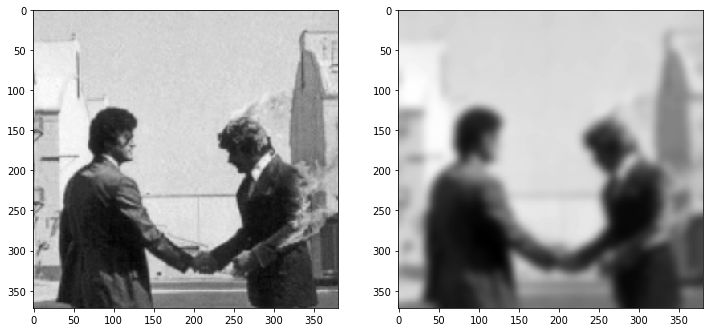

In [16]:
"""

exercise: blur image

"""

from scipy.ndimage import filters
im = np.array(Image.open('floyd.png').convert('L'))
im2 = filters.gaussian_filter(im,5)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im2, cmap='gray')
plt.show()


Number of objects: 30


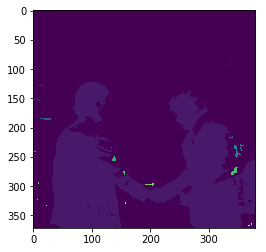

In [17]:
"""

exercise: counting objects

"""

from scipy.ndimage import measurements,morphology

labels, nbr_objects = measurements.label(im<100)
print("Number of objects:", nbr_objects)
plt.figure
plt.imshow(labels)
plt.show()


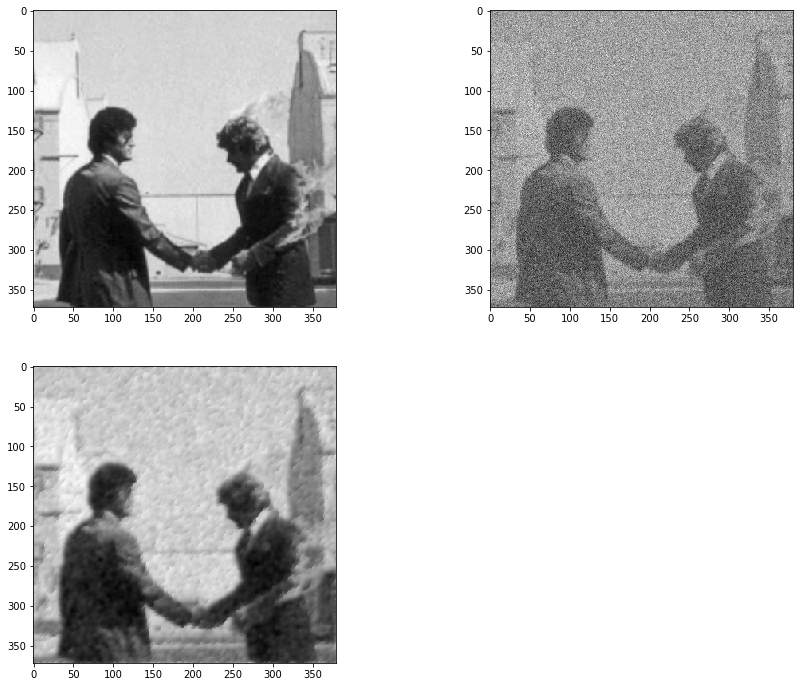

In [22]:
"""

tv denoising

"""
from numpy import *

def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
    using the numerical procedure presented in eq (11) A. Chambolle (2005).
    Input: noisy input image (grayscale), initial guess for U, weight of
    the TV-regularizing term, steplength, tolerance for stop criterion.
    Output: denoised and detextured image, texture residual. """
    m,n = im.shape #size of noisy image
    # initialize
    U = U_init
    Px = im #x-component to the dual field
    Py = im #y-component of the dual field
    error = 1
    while (error > tolerance):
        Uold = U
        # gradient of primal variable
        GradUx = roll(U,-1,axis=1)-U # x-component of U’s gradient
        GradUy = roll(U,-1,axis=0)-U # y-component of U’s gradient
        # update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx
        PyNew = Py + (tau/tv_weight)*GradUy
        NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))
        Px = PxNew/NormNew # update of x-component (dual)
        Py = PyNew/NormNew # update of y-component (dual)
        # update the primal variable
        RxPx = roll(Px,1,axis=1) # right x-translation of x-component
        RyPy = roll(Py,1,axis=0) # right y-translation of y-component
        DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field.
        U = im + tv_weight*DivP # update of the primal variable
        # update of error
        error = linalg.norm(U-Uold)/sqrt(n*m)
    
    return U, im-U


im_gray = np.array(Image.open('floyd.png').convert('L'))

sig = 50
im_noisy = im_gray + sig*random.randn(im_gray.shape[0],im_gray.shape[1])

im_clean, er = denoise(im_noisy,im_noisy,0.1,0.05,100)

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
plt.imshow(im_gray,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(im_noisy,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(im_clean,cmap='gray')
plt.show()

